[![Le Baladin](https://img.shields.io/badge/Le_baladin-Mosaïque_avec_Ciboulette-blue.svg)](https://sites.google.com/view/astronomie-ut1/accueil)

_Dominique Touzan_<sup>1,2</sup>

<sup>1</sup>Notebook: https://anaconda.org/dtouzan/Mosaique-Ciboulette/notebook

<sup>2</sup>Correspondance: [dtouzan@gmail.com](mailto:dtouzan@gmail.com)

Édition   1.0, révision 31/09/2020 - 26/10/2020

---
**Résumé** : Pour cet automne le temps est relativement nuageux et peu de nuit sont au rendez vous. Dans l'observatoire une deuxième place pour un petit instrument est disponible avec une acienne monture goto, le porte filtre récupéré du télescope M603, l'ancien téléobjectif 70-300 et la caméra de suivi PL1-M, voici comment a poussé Ciboulette. Son premier objectif était de fonctionner en mode automatique pour faire des mosaïques des différents amas ouverts de notre voie lactée. L'utilisation de la librairie Indilib[[1]](#ref1) est nécessaire et s'installe facilement, les configurations des différents appareils sont plus fastidieuses. La librairie pyindi-lib a été installé et quelques tests concluant ont été réalisés mais elle n'est pas implémentée dans ce document car les commandes shell indi_setprop et indi_getprop suffisent pour ce premier test. La région d'environ 10° carré est celle du double amas de Persée avec une résolution de 10 seconde-arc/pixel, l'instrument a une focale de 100mm sans suivi automatique.

_Mots-clés_ : Amas - Mosaïque CCD/CMOS - Indilib

---
[![astropy](http://img.shields.io/badge/powered%20by-AstroPy-orange.svg?style=flat)](http://www.astropy.org/)

## Configuration

- Ubuntu server 20.04
- Indilib 1.8.1
- Jupyterlab 2.2.8
- Astropy 4.0.1
- Reproject 0.7.1
- Astroquery 0.4.2

## Shell & Indilib.

Le service indiserver peut être lancé soit après la connexion à l'ordinateur soit avec les sevices Ubuntu, il contien la ligne "**indiserver indi_asi_wheel indi_lx200generic indi_qhy_ccd**". Le shell d'initialisation des trois apareils est **indiC.sh** il est lancé après le pointage de l'instrument sur une étoile connue. Certaines temporisations sont nécéssaire pour bien initialiser l'instrument surtout pour la monture LXD650. Pour le client indilib trois shell sont utilisés, **indiCL.sh** pour la prise d'images, des valeurs de la monture et du filtre utilisé, **indiTrack.sh** pour le déplacement de la monture et **indiSync.sh** pour la synchronisation de la monture.

**indiC.sh**<br/>
```console
#!/bin/bash)

DATE=$(date +"%Y-%m-%d"T"%H:%M:%S")
#Initialisation CCD
indi_setprop "QHY CCD QHY5-M-.CONNECTION.CONNECT=On"
sleep 2
indi_setprop "QHY CCD QHY5-M-.UPLOAD_SETTINGS.UPLOAD_DIR=/home/data-set"
indi_setprop "QHY CCD QHY5-M-.UPLOAD_SETTINGS.UPLOAD_PREFIX=GC_XXX"
indi_setprop "QHY CCD QHY5-M-.CCD_GAIN.GAIN=50"
indi_setprop "QHY CCD QHY5-M-.UPLOAD_MODE.UPLOAD_LOCAL=On"
indi_setprop "QHY CCD QHY5-M-.USB_BUFFER.BUFFER=1024"
indi_setprop "QHY CCD QHY5-M-.FITS_HEADER.FITS_OBSERVER=dtouzan@gmail.com"
indi_setprop "QHY CCD QHY5-M-.FITS_HEADER.FITS_OBJECT=INIT"
indi_setprop "QHY CCD QHY5-M-.ACTIVE_DEVICES.ACTIVE_TELESCOPE=UT2"
indi_setprop "QHY CCD QHY5-M-.WCS_CONTROL.WCS_ENABLE=On"
#Initialisation Filtres
indi_setprop "ASI EFW.CONNECTION.CONNECT=On"
sleep 2
indi_setprop "ASI EFW.FILTER_SLOT.FILTER_SLOT_VALUE=1"
indi_setprop "ASI EFW.FILTER_NAME.FILTER_SLOT_NAME_1=L"
indi_setprop "ASI EFW.FILTER_NAME.FILTER_SLOT_NAME_2=V"
indi_setprop "ASI EFW.FILTER_NAME.FILTER_SLOT_NAME_3=B"
indi_setprop "ASI EFW.FILTER_NAME.FILTER_SLOT_NAME_4=Ha"
indi_setprop "ASI EFW.FILTER_NAME.FILTER_SLOT_NAME_5=OIII"
#Initialisation Monture
indi_setprop "Standard LX200.CONNECTION.CONNECT=On"
indi_setprop "Standard LX200.SYSTEM_PORTS./dev/ttyUSB0=On"
sleep 10
indi_setprop "Standard LX200.TIME_UTC.UTC;OFFSET=$DATE;2"
sleep 10
indi_setprop "Standard LX200.Sites.Site 4=On"
sleep 5
indi_setprop "Standard LX200.Site Name.Name=VIR"
sleep 5
indi_setprop "Standard LX200.GEOGRAPHIC_COORD.LAT;LONG;ELEV=49.52;359.70;100"
sleep 3
indi_setprop "Standard LX200.Alignment.Polar=On"
sleep 3
indi_setprop "Standard LX200.TELESCOPE_PARK.UNPARK=On"
sleep 3
indi_setprop "Standard LX200.TELESCOPE_SLEW_RATE.2x=On"
sleep 3
indi_setprop "Standard LX200.TELESCOPE_TRACK_MODE.TRACK_SIDEREAL=On"
sleep 3
indi_setprop "Standard LX200.TELESCOPE_INFO.TELESCOPE_APERTURE=50"
indi_setprop "Standard LX200.TELESCOPE_INFO.TELESCOPE_FOCAL_LENGTH=100"
indi_setprop "Standard LX200.SCOPE_CONFIG_NAME.SCOPE_CONFIG_NAME=UT2"
#Alpha Pegase
indi_setprop "Standard LX200.ON_COORD_SET.SYNC=On"
sleep 3
indi_setprop "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=0.96638;60.82861"
indi_setprop "Standard LX200.ON_COORD_SET.TRACK=On"
indi_setprop "Standard LX200.TELESCOPE_SLEW_RATE.1x=On"
indi_setprop "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=0.96638;60.82861"
```

**indiCL.sh**<br/>
```console
#!/bin/bash

#Initialise l'objet dans l'entête fits (ne pas mettre d'espace)
OBJECT=$1
indi_setprop "QHY CCD QHY5-M-.FITS_HEADER.FITS_OBJECT=$OBJECT"
#Get RA, DEC, LAT, LONG, ALTITUDE
indi_getprop|grep EQUATORIAL_EOD_COORD.RA|cut -d'=' -f2 > COORD_RA.csv
indi_getprop|grep EQUATORIAL_EOD_COORD.DEC|cut -d'=' -f2 > COORD_DEC.csv
indi_getprop|grep GEOGRAPHIC_COORD.LAT|cut -d'=' -f2 > COORD_LAT.csv
indi_getprop|grep GEOGRAPHIC_COORD.LONG|cut -d'=' -f2 > COORD_LONG.csv
indi_getprop|grep GEOGRAPHIC_COORD.ELEV|cut -d'=' -f2 > COORD_ELEV.csv
#Get filter name
FILTER_NUM=$(indi_getprop|grep FILTER_SLOT_VALUE|cut -d'=' -f2)
indi_getprop|grep FILTER_SLOT_NAME_$FILTER_NUM|cut -d'=' -f2 > SLOT_VALUE.csv
#Get focal length
indi_getprop|grep TELESCOPE_FOCAL|cut -d'=' -f2 > TELESCOPE_FOCAL.csv
TIME=$2
#Shoot, 2 fois 35 secondes pour laisser le temps de la prise et de l'enregistrement
indi_setprop "QHY CCD QHY5-M-.CCD_EXPOSURE.CCD_EXPOSURE_VALUE=$TIME"
sleep 35s
sleep 35s
```

**indiTrack.sh**<br/>
```console
#!/bin/bash

#Format RA heures décimaux
#Format DEC en degrés décimaux
RA=$1
DEC=$2
VALUE=$RA';'$DEC
echo $VALUE
indi_setprop "Standard LX200.ON_COORD_SET.TRACK=On"
indi_setprop "Standard LX200.TELESCOPE_SLEW_RATE.1x=On"
sleep 1s
echo "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=$VALUE"
indi_setprop "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=$VALUE"
sleep 5s
```

**indiSync.sh**<br/>
```console
#!/bin/bash

# Format RA heures décimaux
# Format DEC en degrés décimaux
RA=$1
DEC=$2
VALUE=$RA';'$DEC
echo $VALUE
indi_setprop "Standard LX200.ON_COORD_SET.SYNC=On"
indi_setprop "Standard LX200.TELESCOPE_SLEW_RATE.1x=On"
sleep 1s
echo "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=$VALUE"
indi_setprop "Standard LX200.EQUATORIAL_EOD_COORD.RA;DEC=$VALUE"
sleep 1s
```

## Configuration

In [116]:
import numpy as np
import time
from IPython.display import Image
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy import wcs
from astropy import units as u
from astropy.time import Time
from astropy.io import ascii
import matplotlib.pyplot as plt
from astroquery.vizier import Vizier
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
import astropy.coordinates as coord
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from matplotlib.colors import LogNorm
import os

In [117]:
object_name = 'NGC869' # Pas d'espace
time_shoot = '30' # En seconde
inc_RA_deg = 0.35 # Incrément de déplacement de la monture en RA
inc_DEC_deg = -2.8 # Incrément de déplacement de la monture en DEC
frame = [[1,2,3,4],[5,6,7,8],[9,10,11,12]] # Nombre d'image 4 x DEC par 3 x RA
dataset = '/home/data-set/GC_' # Répertoire de stockage
simulation = False
index = 0
i_column = len(frame)-1

## Prise des images

La prise des images se fait après le déplacement sur la première image de la mosaïque.<br/>
L'utilisation de **indiTrack.sh** et **indiSync.sh** est nécessaire sur une monture bien ancienne pour être relativement bien positionné.<br/>
Le programme prend les douzes images à la suite du haut vers le bas et d'ouest en est, chaque image est sauvegardée puis l'entête fits est modifiée,<br/>
les valeurs **WCS** (base monture) sont ajoutées et l'image est sauvegardée avec le nom configuré.

Conseil : Utiliser le logiciel **Carte du ciel** (*skychart*) en mode client pour visualiser le déplacement de la monture

In [4]:
# Indi Client

# Pour test sans monture 
if simulation :
    RA = '0.42000'
    DEC = '44.38027'
    LAT = '49.52'    
    LONG = '359.7'
    time_shoot = '1' # in second No space

for frameid in frame :
    i_line = len(frameid)-1
    
    for idx in frameid :
    
        print('>Shoot...')
        os.system("./indiCL.sh" + " " + object_name + " " + time_shoot)
        
        if not simulation :
            # Lecture RA
            data = ascii.read("COORD_RA.csv",data_start = 0,format = 'csv') 
            for line in data :
                RA = line[0]
    
            # Lecture DEC
            data = ascii.read("COORD_DEC.csv",data_start = 0,format = 'csv') 
            for line in data :
                DEC = line[0]
    
            # Lecture LAT
            data = ascii.read("COORD_LAT.csv",data_start = 0,format = 'csv') 
            for line in data :
                LAT = line[0]
    
            # Lecture LONG
            data = ascii.read("COORD_LONG.csv",data_start = 0,format = 'csv') 
            for line in data :
                LONG = line[0]

        # RA.deg, DEC.deg for WCS
        RA_deg = (15*float(RA))
        DEC_deg = float(DEC) 
    
        # Lecture du filtre
        data = ascii.read("SLOT_VALUE.csv",data_start = 0,format = 'csv') 
        for line in data :
            filter_name = line[0]
    
        # Lecture de la focale
        data = ascii.read("TELESCOPE_FOCAL.csv",data_start = 0,format = 'csv') 
        for line in data :
            focale = line[0]
     
        # mini-log
        print('>RA '+str(RA)+'   DEC '+str(DEC)+'   FRAME '+str(idx)+'   FILTER '+str(filter_name))
           
        # Modification des entête fits
        if (idx < 10) :
            print('>' + dataset + '00' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '00' + str(idx) + '.fits')
        else : 
            print('>' + dataset + '0' + str(idx) + '.fits')
            fits_file = get_pkg_data_filename(dataset + '0' + str(idx) + '.fits')             
            
        fits.setval(fits_file, 'RADESYSA', value='ICRS', comment='Equatorial coordinate system', savecomment=True)
        fits.setval(fits_file, 'FRAMEID', value=idx+index, comment='Frame ID', savecomment=True)
        fits.setval(fits_file, 'FILTER', value=filter_name, comment='Filter name', savecomment=True)
        fits.setval(fits_file, 'SITELAT', value=LAT, comment='Observatory latitude', savecomment=True)
        fits.setval(fits_file, 'SITELONG', value=LONG, comment='Observatory longitude', savecomment=True)
        fits.setval(fits_file, 'EQUINOX', value=2000.0, comment='Equinox date', savecomment=True)
        fits.setval(fits_file, 'DATATYPE', value='Intensity', comment='Type of data', savecomment=True)
        fits.setval(fits_file, 'MJD-OBS', value=0.0, comment='MJD of start of obseration', savecomment=True)
        fits.setval(fits_file, 'JD-OBS', value=0.0, comment='JD of start of obseration', savecomment=True)

        hdu = fits.open(fits_file)[0]
        header = hdu.header

        # Modification du nom du télescope
        header['TELESCOP'] = 'UT2'

        # Modification du JD et MJD
        date_obs = header['DATE-OBS']
        time_obs = Time(header['DATE-OBS'])
        header['JD-OBS'] = time_obs.jd
        header['MJD-OBS'] = time_obs.mjd

        # Eléments pour CRPIX
        crpix1 = int(header['NAXIS1'])/2
        crpix2 = int(header['NAXIS2'])/2

        # Elément pour CDELT
        cdelt1 = (206*int(header['PIXSIZE1'])*int(header['XBINNING'])/focale)/3600
        cdelt2 = (206*int(header['PIXSIZE2'])*int(header['YBINNING'])/focale)/3600

        # Header WCS
        w = wcs.WCS(naxis=2)
        w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        # CRVAL position RA,DEC en degrés
        w.wcs.crval = [RA_deg, DEC_deg] 
        # CRPIX Vecteur à 2 éléments donnant les coordonnées X et Y du pixel de référence 
        # (def = NAXIS / 2) dans la convention FITS (le premier pixel est 1,1)
        w.wcs.crpix = [crpix1, crpix2]
        # CDELT Vecteur à 2 éléments donnant l'incrément physique au pixel de référence
        w.wcs.cdelt = [-cdelt1, cdelt2] 

        # Now, write out the WCS object as a FITS header
        hdu.header = header + w.to_header()
        # Modification des NAXIS

        # Header and data
        hdr = hdu.header
        data = np.fliplr(hdu.data) # inversion verticale

        if (idx < 10) :
            print('>' + dataset + object_name + '_00' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_00' + str(idx) + '.fits', data, hdr)
        else :   
            print('>' + dataset + object_name + '_0' + str(idx) + '.fits')
            fits.writeto(dataset + object_name + '_0' + str(idx) + '.fits', data, hdr)

        if i_line > 0 :
            # Déplacement de la monture en DEC
            print('>Track DEC...')
            RA = str(RA)
            DEC = str(float(DEC) + inc_DEC_deg)
            if not simulation :
                os.system("./indiTrack.sh" + " " + RA + " " + DEC)
 
            i_line = i_line - 1
        # Fin boucle DEC
    
    if i_column > 0 : 
        # Déplacement de la monture en RA
        print('>Track RA... positionnement')
        RA = str(float(RA) + inc_RA_deg)
        DEC = str(float(DEC) - (3 * inc_DEC_deg))   
        if not simulation :
            os.system("./indiTrack.sh" + " " + RA + " " + DEC)
        
        # Attente de 10s pour déplacement long  
        time.sleep(10) 
        index = index + 4
        i_column = i_column - 1
    # Fin boucle RA
    

>Shoot...
>RA 1.9283333333333332   DEC 59.96666666666667   FRAME 1   FILTER L
>/home/data-set/GC_001.fits
>/home/data-set/GC_NGC869_001.fits
>Track DEC...
>Shoot...
>RA 1.9283333333333332   DEC 57.15   FRAME 2   FILTER L
>/home/data-set/GC_002.fits
>/home/data-set/GC_NGC869_002.fits
>Track DEC...
>Shoot...
>RA 1.9283333333333332   DEC 54.333333333333336   FRAME 3   FILTER L
>/home/data-set/GC_003.fits
>/home/data-set/GC_NGC869_003.fits
>Track DEC...
>Shoot...
>RA 1.9283333333333332   DEC 51.516666666666666   FRAME 4   FILTER L
>/home/data-set/GC_004.fits
>/home/data-set/GC_NGC869_004.fits
>Track RA... positionnement
>Shoot...
>RA 2.275   DEC 59.85   FRAME 5   FILTER L
>/home/data-set/GC_005.fits
>/home/data-set/GC_NGC869_005.fits
>Track DEC...
>Shoot...
>RA 2.275   DEC 57.05   FRAME 6   FILTER L
>/home/data-set/GC_006.fits
>/home/data-set/GC_NGC869_006.fits
>Track DEC...
>Shoot...
>RA 2.275   DEC 54.233333333333334   FRAME 7   FILTER L
>/home/data-set/GC_007.fits
>/home/data-set/GC_NGC

In [118]:
#
# Intérogation de la base du CDS avec Vizier
# RA étoile dans le tableau table_ra
# DEC étoile dans le tableau table_dec
# La grosseur des étoiles est dans le tableau table_Marker
#
def RegionInCatalog(astre_ra,astre_dec,angle_width,angle_height,mag,catalog_name,field_ra,field_dec,field_mag):
    # Création du tableau
    table_ra = []
    table_dec = []
    table_marker = []
    
    # Recherche dans le catalog 
    # Field catalog : _RAJ2000, _DEJ2000, Vmag, r'mag, Gmag ...
    v = Vizier(columns=[field_ra, field_dec, field_mag])
    
    # Nombre limite de recherche
    v.ROW_LIMIT = 500000
    
    # Recherche et création de la table
    mag_format = '<'+str(mag)
    result = v.query_region(coord.SkyCoord(ra=astre_ra, dec=astre_dec, unit=(u.deg, u.deg),frame='icrs'), width=Angle(angle_width, "deg"), 
                            height=Angle(angle_height, "deg"), catalog=catalog_name,column_filters={'Vmag':mag_format})
    for table_name in result.keys():
        table = result[table_name]
        for line in table:
            ra = float(line[0])
            dec = float(line[1])
            Mv = float(line[2])
            if Mv != 'masked' :
                marker_size = 1
                if Mv < 12:
                    marker_size = 1
                if Mv < 11:
                    marker_size = 1    
                if Mv < 10:
                    marker_size = 3  
                if Mv < 9:
                    marker_size = 5
                if Mv < 8:
                    marker_size = 8
                if Mv < 7:
                    marker_size = 20
                if Mv < 6:
                    marker_size = 35
                if Mv < 5:
                    marker_size = 50
                table_ra.append(ra)
                table_dec.append(dec)
                table_marker.append(marker_size)
                
            else :
                table_ra.append(ra)
                table_dec.append(dec)
                table_Marker.append(0)
        
        return Table([table_ra,table_dec,table_marker], names=['RA', 'DEC', 'MARKER'])

## Affichage & positionnement

En affichant les images au format fits on édite un champ de carte pour vérifier le positionnement effectif et la diférence de champ. Sur ces prises il y a effectivement un mauvais réglage ou mise en position de la monture mais plus loin les entête **WCS** seront repositionnées.

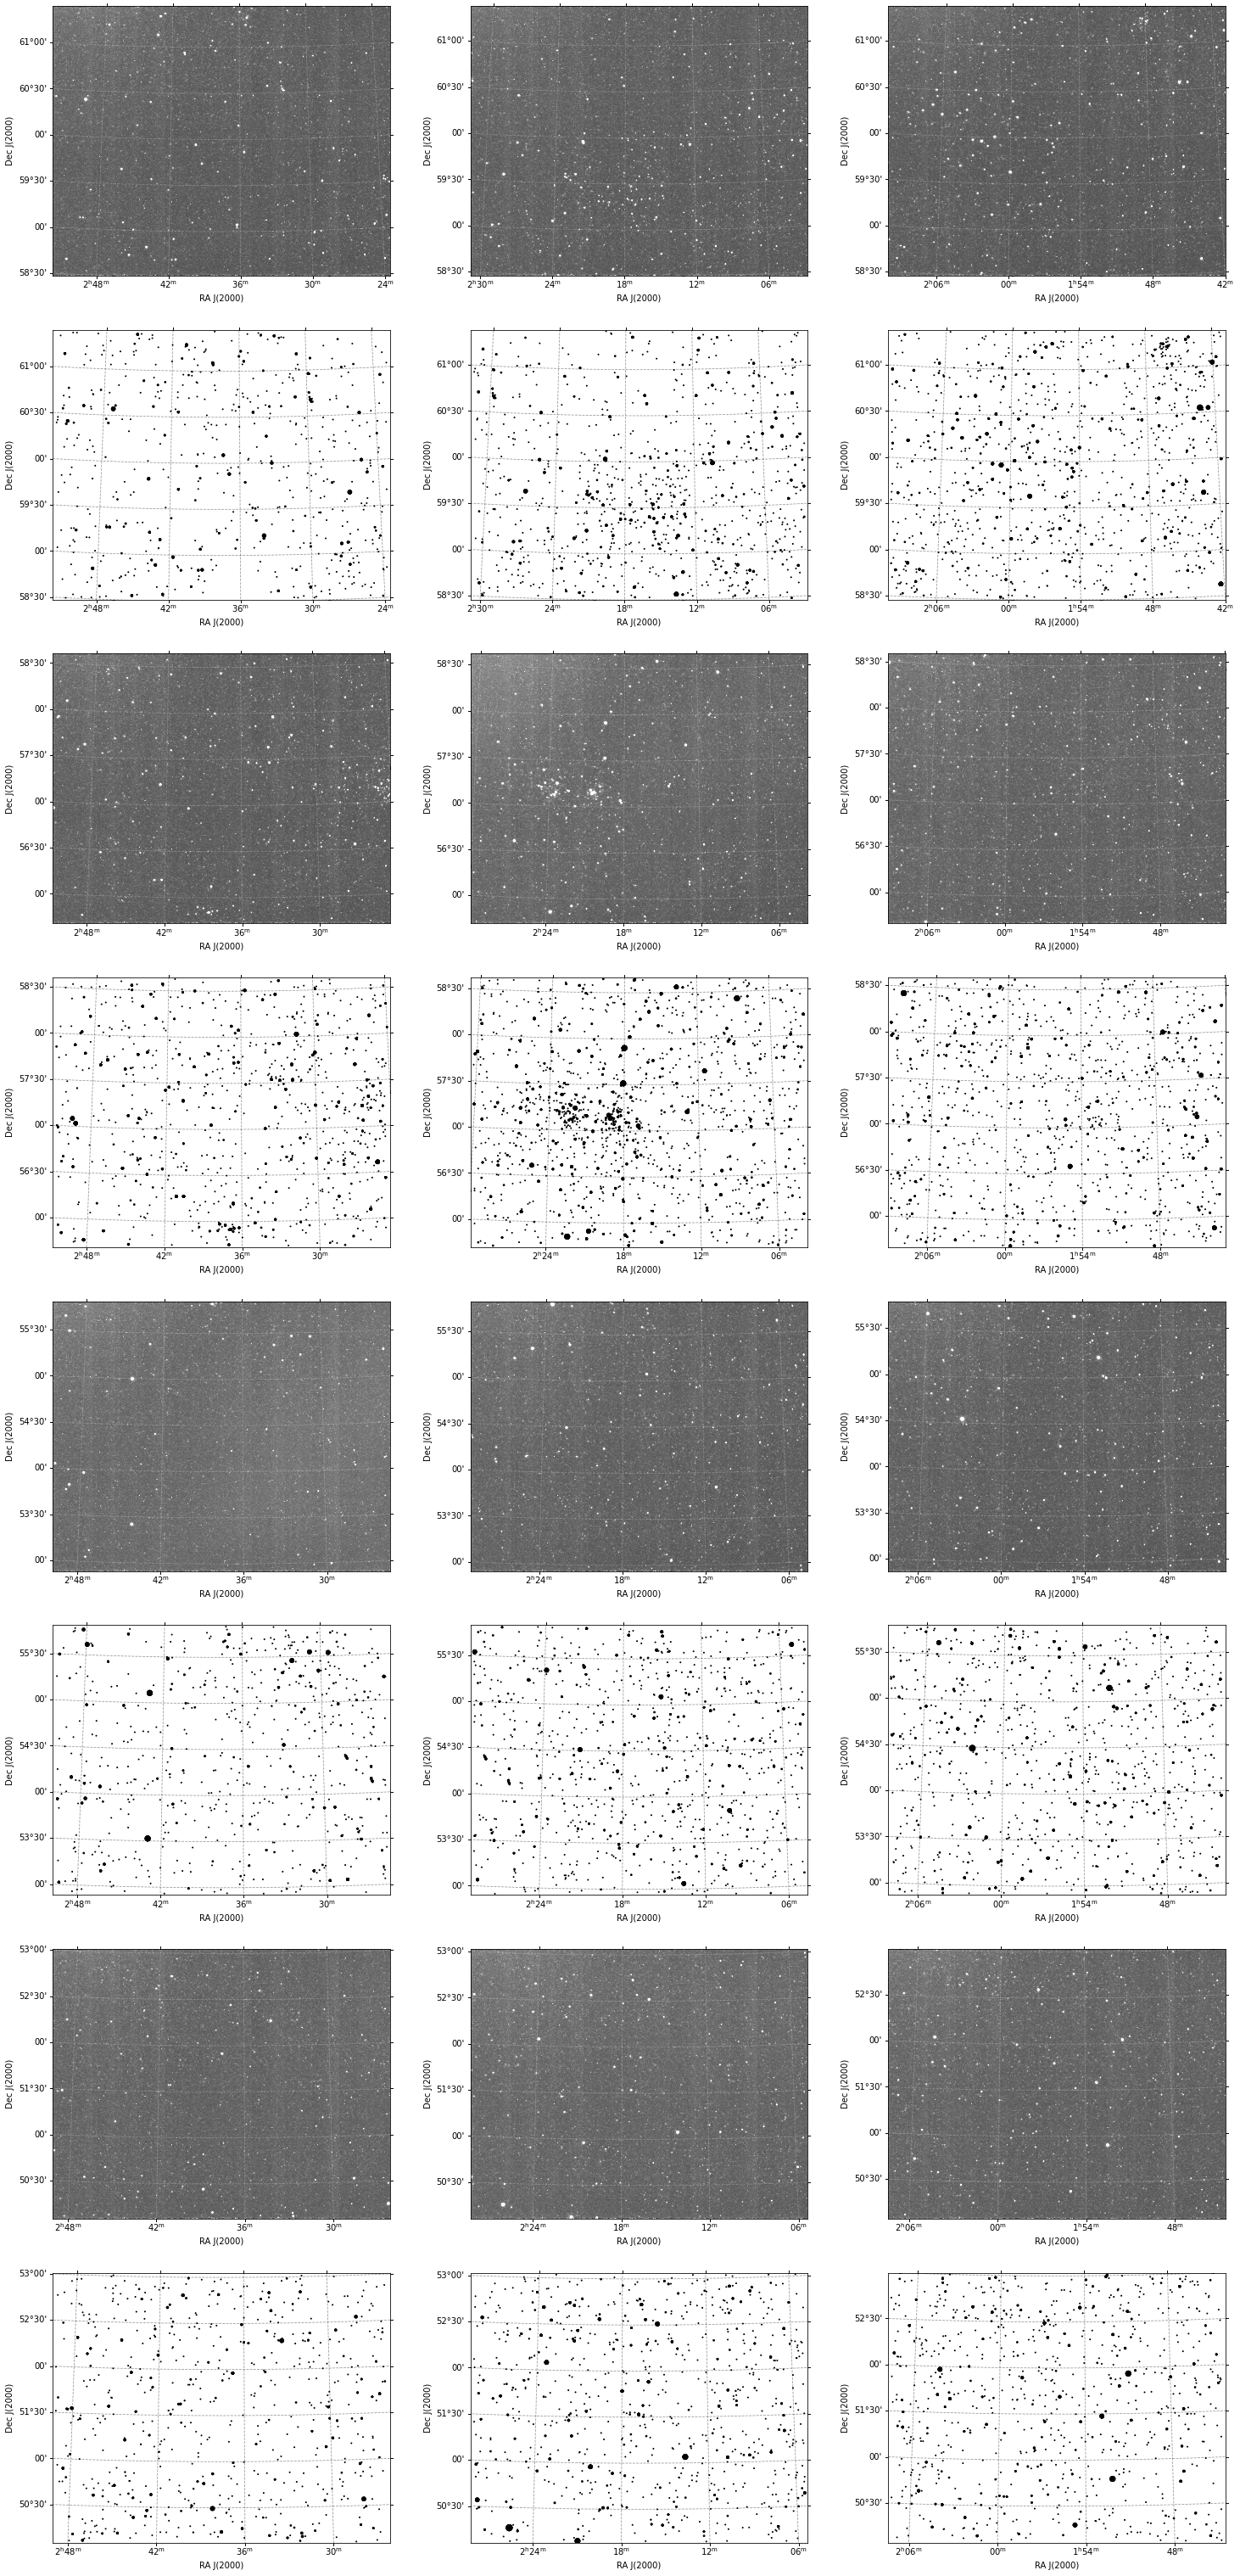

In [119]:
frame = [[9,5,1],[10,6,2],[11,7,3],[12,8,4]]
fig = plt.figure(figsize=(25,55))
column = 1
for frameid in frame :
    for idx in frameid :
        if (idx < 10) :
            fits_file = get_pkg_data_filename(dataset + object_name + '_00' + str(idx) + '.fits')
        else :   
            fits_file = get_pkg_data_filename(dataset + object_name + '_0' + str(idx) + '.fits')
        hdu = fits.open(fits_file)[0]
        wcs_file = wcs.WCS(hdu.header)
        header = hdu.header
        RA_deg = float(header['CRVAL1'])
        DEC_deg = float(header['CRVAL2'])      
        EQUINOX = str(int(header['EQUINOX']))
        mag = 11.5
        catalog = 'GSC2.3'
        data_field = RegionInCatalog(RA_deg, DEC_deg,3.6,2.9,mag,catalog,'_RAJ2000', '_DEJ2000', 'Vmag')
        #catalog = 'APASS'
        #data_field = RegionInCatalog(RA_deg, DEC_deg,3.5,2.7,mag,catalog,'RAJ2000', 'DEJ2000', 'Vmag')
    
        ax = fig.add_subplot(8,3,column, projection=wcs_file)
        fig.add_axes(ax) 
        ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
        plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = 8, vmax = 45)
        plt.xlabel('RA J('+EQUINOX+')')
        plt.ylabel('Dec J('+EQUINOX+')')
        
        ax = fig.add_subplot(8,3,column+3, projection=wcs_file)
        ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.40)
        plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = -255, vmax = 0)
        ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER'],edgecolor='black', facecolor='black')
        plt.xlabel('RA J('+EQUINOX+')')
        plt.ylabel('Dec J('+EQUINOX+')')
        column = column + 1
        
    column = column + 3
             
plt.show()

## Affichage affiné

Pour repositionner correctement les champs des images ici il est utilisé la méthode manuelle à travers les variables de correction **RA_diff** et **DEC_diff** sur les valeurs des champs **WCS**, une autre méthode serai d'utiliser le service **astrometry.net** et **indi_astrometry**.

Après modiffication en prenant les coordonnées sur Aladin Sky Atlas le positionnement est relativement bon, on peut passé à l'étape de la mosaïque. pour information l'entête fits est éditée.

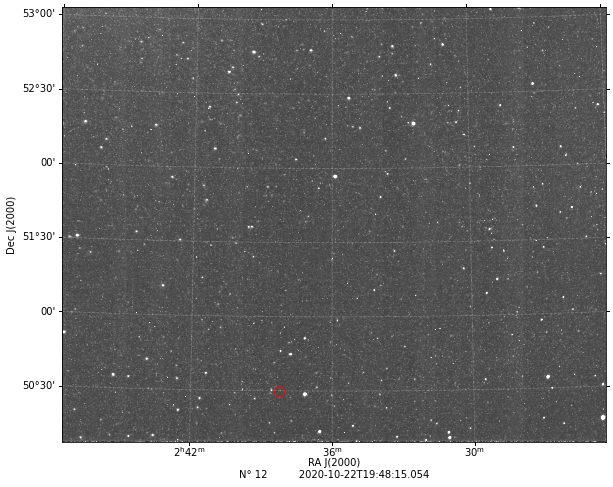

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1280                                                  
NAXIS2  =                 1024                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ROWORDER= 'TOP-DOWN'           / Row Order                                      
INSTRUME= 'QHY CCD QHY5-M-'    / CCD Name                                       
TELESCOP= 'UT2     '           / Telescope name                                 
OBSERVER= 'dtouzan@gmail.com'  / Observer name                                  
OBJECT  = 'NGC869  '           / Object name                                    
EXPTIME =         3.000000E+

In [111]:
RA_ref = 39.5532770
DEC_ref = 50.49190200
RA_diff = -0.028
DEC_diff = 0.037

frame = 12

if (frame < 10) :
    fits_file = get_pkg_data_filename(dataset + object_name + '_00' + str(frame) + '.fits')
else :
    fits_file = get_pkg_data_filename(dataset + object_name + '_0' + str(frame) + '.fits')

hdu = fits.open(fits_file)[0]
wcs_file = wcs.WCS(hdu.header)
header = hdu.header

date_obs = header['DATE-OBS']
EQUINOX = str(int(header['EQUINOX']))
RA_d = RA_diff * 15
DEC_d = DEC_diff

header['CRVAL1'] = header['CRVAL1'] + RA_d
header['CRVAL2'] = header['CRVAL2'] + DEC_d

hdu.header = header
wcs_file = wcs.WCS(hdu.header)

hdr = hdu.header
data = hdu.data


if (frame < 10) :
    os.system("rm" + " -f" + " " + dataset + object_name + "_XY_00" + str(frame) + ".fits")
    fits.writeto(dataset + object_name + '_XY_00' + str(frame) + '.fits', data, hdr)
else :   
    os.system("rm" + " -f" + " " + dataset + object_name + "_XY_0" + str(frame) + ".fits")
    fits.writeto(dataset + object_name + '_XY_0' + str(frame) + '.fits', data, hdr)        
            
if (frame < 10) :
    fits_file = get_pkg_data_filename(dataset + object_name + '_XY_00' + str(frame) + '.fits')
else :   
    fits_file = get_pkg_data_filename(dataset + object_name + '_XY_0' + str(frame) + '.fits')
    
hdu = fits.open(fits_file)[0]
wcs_file = wcs.WCS(hdu.header)
header = hdu.header
RA_deg = float(header['CRVAL1'])
DEC_deg = float(header['CRVAL2'])
    
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=wcs_file)
fig.add_axes(ax) 
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
plt.imshow(hdu.data, origin='lower', cmap='gray',vmin = 8, vmax = 55)
ax.scatter(RA_ref, DEC_ref , transform=ax.get_transform('icrs'), s=100,edgecolor='red', facecolor='None')
plt.xlabel('RA J('+EQUINOX+')' + '\n' + 'N° '+ str(frame) + '          ' + str(date_obs))
plt.ylabel('Dec J('+EQUINOX+')')
    
plt.show()
# Affiche l'entête fits modifiée
header

## Mosaïque & affichage

Après création de la mosaïque avec reproject celle-ci est affichée puis une carte de champ avec le catalogue GSC2.3[[2]](#ref2) de magnitude inférieur à 11.5 y est ajoutée. Pour information les champs des images sont affichés en dernier. Il reste un légé décalage en ascension droite.

In [112]:
# table : table des noms de fichier fits
table_fits = []

for idx in range(1,13) :
    
    if (idx < 10) :
        fits_name = dataset + object_name + '_XY_00' + str(idx) + '.fits'
    else :   
        fits_name = dataset + object_name + '_XY_0' + str(idx) + '.fits'
    table_fits.append(get_pkg_data_filename(fits_name))

# table : table de fichier fits
table = []

for line in table_fits : 
    table.append(fits.open(line))
    
# hdus : liste des hdu des fichier fits
hdus = []

for file in table :
    hdus.append(file[0])


# Sortie des WCS et tailles des images et recalibration.
# Résolution 0.16 arcseconde
wcs_out, shape_out = find_optimal_celestial_wcs(hdus, frame='icrs',  projection='TAN', resolution=10 * u.arcsec)
# Pour affichage des résultats
hdr = wcs_out.to_header()


# Création de la mosaïc et des champs visuels
mosaic, footprint = reproject_and_coadd(hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp,combine_function = 'mean', match_background = True, background_reference = 6)

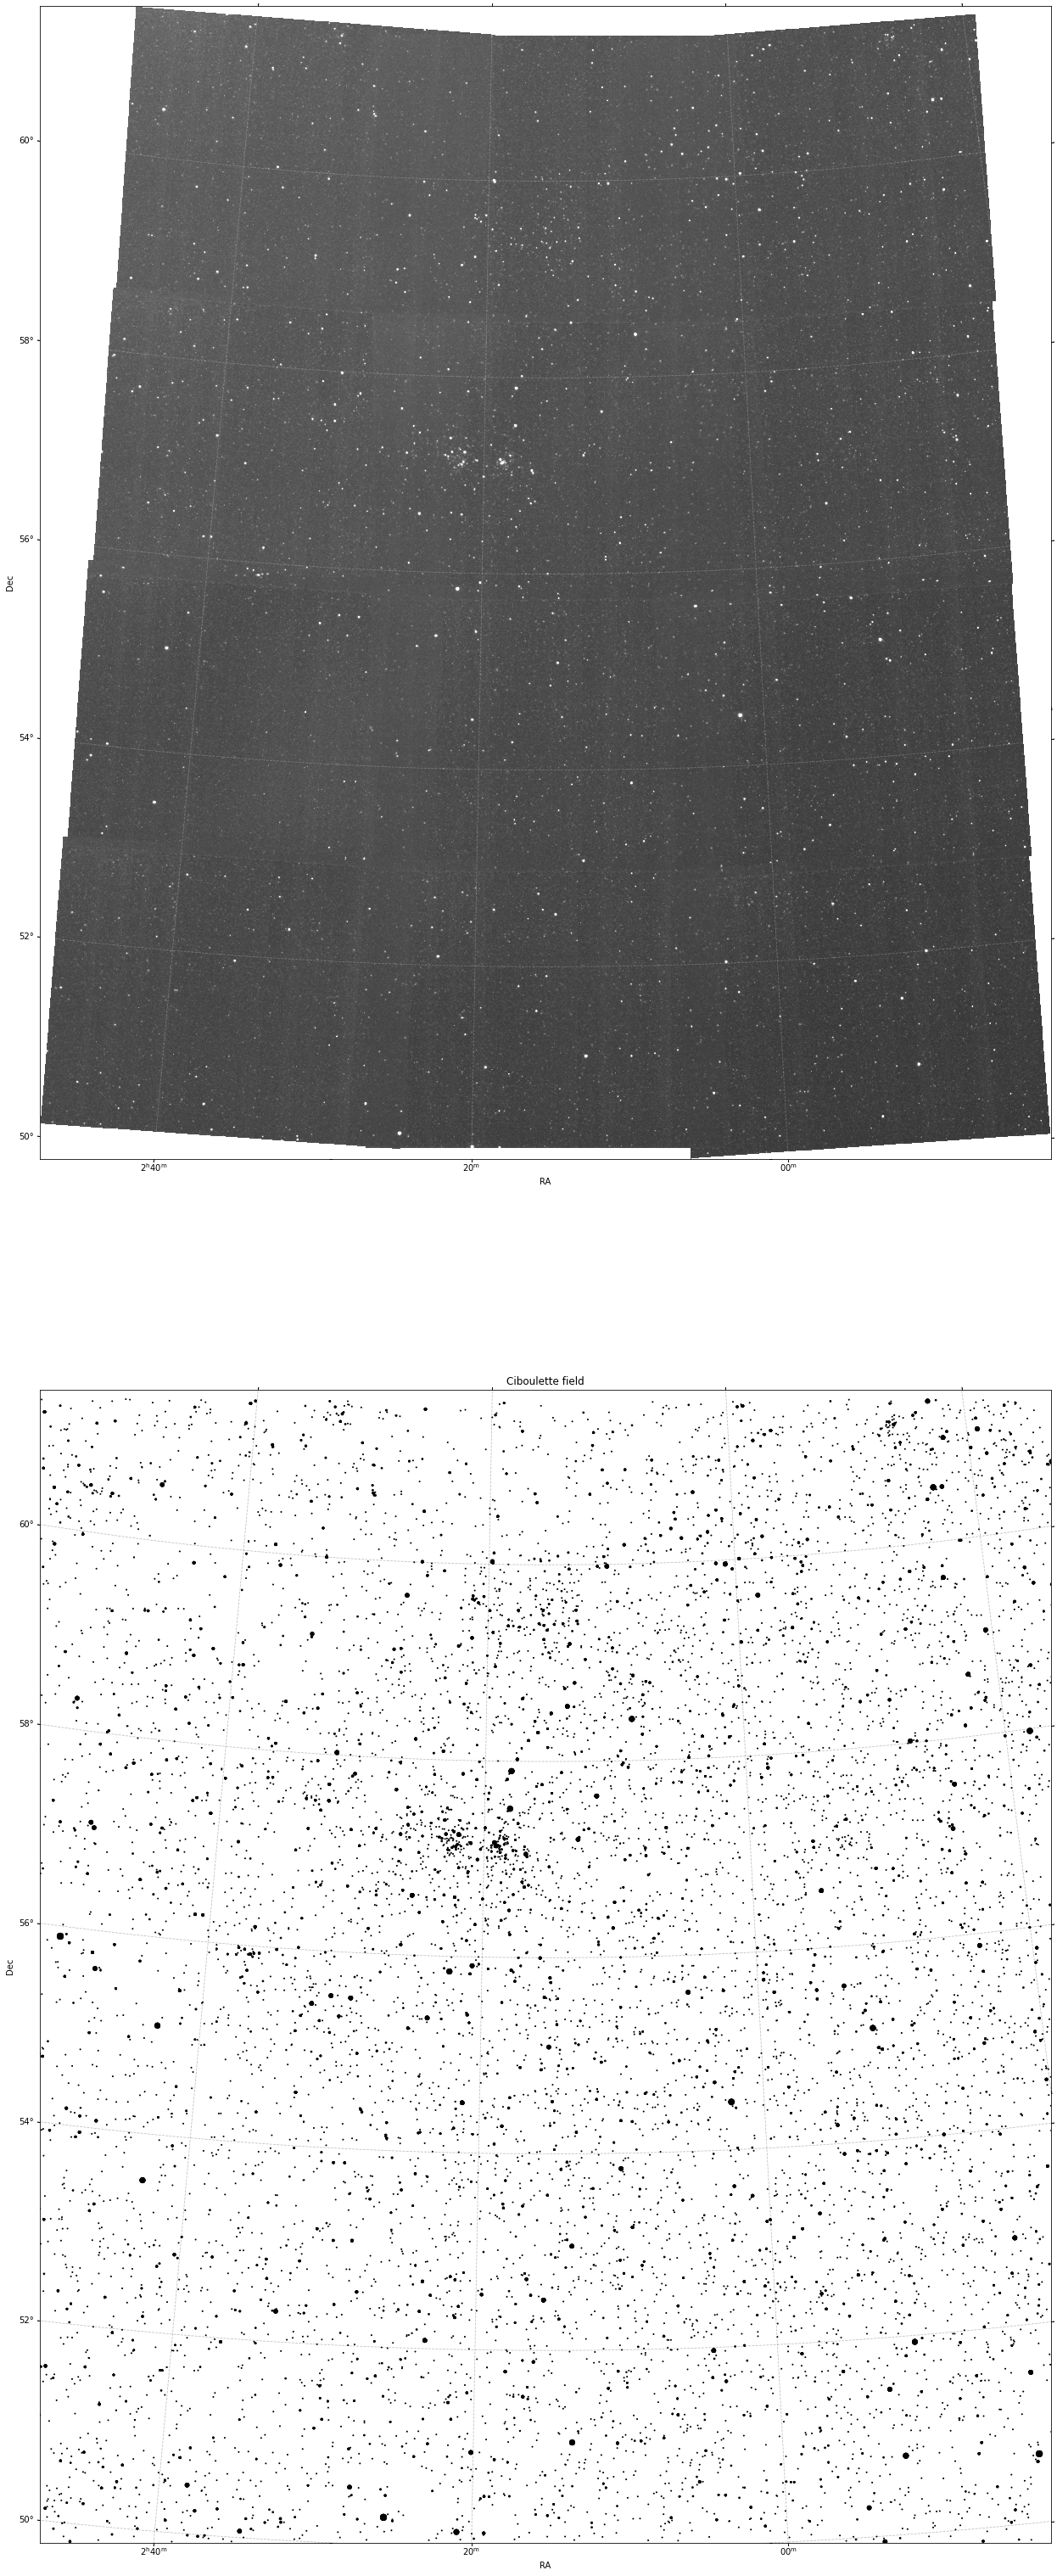

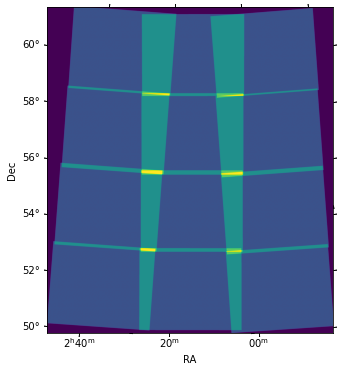

In [120]:
plt.figure(figsize=(30, 55))
ax = plt.subplot(211, projection = wcs_out)
ax.grid(b = False, alpha = 0)

RA_deg = float(hdr['CRVAL1'])
DEC_deg = float(hdr['CRVAL2'])
im = ax.imshow(mosaic, cmap='gray', origin='lower', vmin=5, vmax=65)
ax.grid(b = True, linestyle = '--', color = 'white', alpha = 0.25)
plt.xlabel('RA')
plt.ylabel('Dec')

mag = 11.5
catalog = 'GSC2.3'
data_field = RegionInCatalog(RA_deg, DEC_deg,10.8,11.6,mag,catalog,'_RAJ2000', '_DEJ2000', 'Vmag')

ax = plt.subplot(212, projection = wcs_out)
ax.scatter(data_field['RA'], data_field['DEC'], transform=ax.get_transform('icrs'), s=data_field['MARKER'],edgecolor='black', facecolor='black')
ax.set_title('Ciboulette field')
im = ax.imshow(mosaic, cmap='binary', origin='lower', vmin=0, vmax=0)
ax.grid(b = True, linestyle = '--', color = 'black', alpha = 0.25)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection = wcs_out)
ax.grid(b = False, alpha = 0)
im2 = ax.imshow(footprint, origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

## Références
---

<a id='ref1'></a>
1. Indilib, https://www.indilib.org/
<a id='ref2'></a>
2. VizieR, https://vizier.u-strasbg.fr/viz-bin/VizieR

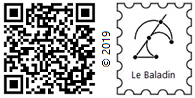

In [6]:
display(Image('signature.png'))